多项式回归
模型选择，欠拟合，过拟合
evaluate_loss

In [1]:
import math
import numpy as np
import torch
from torch import nn
from torch.utils import data
import matplotlib.pyplot as plt
from IPython import display
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))    # 求指数
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 1.5493],
         [-0.0056]]),
 tensor([[ 1.0000e+00,  1.5493e+00,  1.2002e+00,  6.1985e-01,  2.4009e-01,
           7.4396e-02,  1.9211e-02,  4.2520e-03,  8.2347e-04,  1.4176e-04,
           2.1963e-05,  3.0935e-06,  3.9941e-07,  4.7601e-08,  5.2679e-09,
           5.4412e-10,  5.2689e-11,  4.8019e-12,  4.1332e-13,  3.3704e-14],
         [ 1.0000e+00, -5.5678e-03,  1.5500e-05, -2.8767e-08,  4.0042e-11,
          -4.4589e-14,  4.1377e-17, -3.2911e-20,  2.2905e-23, -1.4170e-26,
           7.8895e-30, -3.9934e-33,  1.8528e-36, -7.9356e-40,  3.1529e-43,
          -0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00]]),
 tensor([6.3354, 4.9978]))

In [4]:
def accuracy(y_hat, y):  #@save
    """
    计算预测正确的数量
    :param y_hat: 预测的y数据
    :param y: 正确的标签
    :return: 正确的数量
    """
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)    # 返回下标
    cmp = y_hat.type(y.dtype) == y
    # print(cmp)
    return float(cmp.type(y.dtype).sum())


class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def evaluate_accuracy(net, data_iter):  #@save
    """
    计算在指定数据集上模型的精度
    :param net: 
    :param data_iter: 
    :return: 预测正确的数量/总的数量
    """
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式,评估模式意味着在推理时，模型不会进行参数更新
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]


from matplotlib_inline import backend_inline


def use_svg_display():  #@save
    """使用svg格式在Jupyter中显示绘图"""
    backend_inline.set_matplotlib_formats('svg')


def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        # print(x, y)
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()  # 清除图标当前内容 
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)   # 显示更新后的图表
        display.clear_output(wait=True)     # 用于清除之前的图表显示，确保只显示最新的图表。
# 当 wait=True 时，clear_output() 函数会等待新的输出出现之前清除旧的输出。这样做可以保持输出区域的整洁，避免在更新内容时出现混乱的情况。

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    train_metrics = None
    test_acc = None
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    # 如果assert 没有满足，会触发 AssertionError 异常，并将指定的消息（可选）作为异常消息输出。
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [5]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [6]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)
        

def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = load_array((train_features, train_labels.reshape(-1,1)), batch_size)
    test_iter = load_array((test_features, test_labels.reshape(-1,1)), batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.9910607  1.2186619 -3.392217   5.587662 ]]


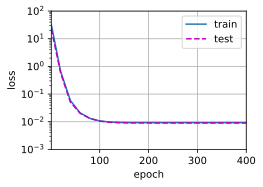

In [7]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

weight: [[2.6313035 5.1124425]]


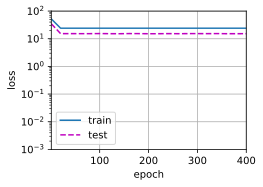

In [8]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

weight: [[ 4.9849014   1.2413445  -3.3591595   5.4782486  -0.15320511  0.33718356
   0.47355723 -0.24667244  0.10291637  0.03745794 -0.02726329 -0.16691238
   0.2041738   0.18756773 -0.08165257  0.16182497  0.1696913   0.08252091
   0.16843034 -0.18353234]]


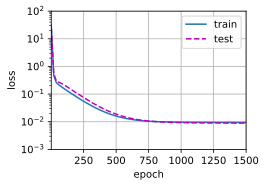

In [9]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:], num_epochs=1500)